In [87]:
import pandas as pd
import numpy as np
dataRaw = pd.read_csv("Energy_Data_20200920_20231027.csv")

dataRaw

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20T00:00:00Z,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17
1,2020-09-20T00:30:00Z,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17
2,2020-09-20T01:00:00Z,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00
3,2020-09-20T01:30:00Z,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00
4,2020-09-20T02:00:00Z,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99
...,...,...,...,...,...,...,...,...,...
54379,2023-10-27T21:30:00Z,NaN,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47
54380,2023-10-27T22:00:00Z,NaN,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31
54381,2023-10-27T22:30:00Z,NaN,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31
54382,2023-10-27T23:00:00Z,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68


In [ ]:
'''
Part Function
'''

In [285]:
def dfPropre(csv, nc):
    """
    :param csv : a specific CSV file
    :param nc : a specific NC file
    :return a merge dataset with all the data
    """
    import pandas as pd
    import xarray as xr
    
    dataRaw = csv
    dwd_solar = nc

    dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)
    dataRaw['year'] = dataRaw['dtm'].dt.year
    dataRaw['month'] = dataRaw['dtm'].dt.month
    dataRaw['day'] = dataRaw['dtm'].dt.day
    dataRaw['hour'] = dataRaw['dtm'].dt.hour
    dataRaw['minute'] = dataRaw['dtm'].dt.minute
    dataRaw['second'] = dataRaw['dtm'].dt.second

    dataRawNoDTM = dataRaw.drop("dtm",axis=1)
    dataRawNoDTM = imputationKNN(dataRawNoDTM)
    dataRawNoDTM["dtm"]=dataRaw["dtm"]
    
    dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_featuresInter = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
    dwd_solar_features = dwd_solar_featuresInter.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

    dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
    dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

    modelling_table = dwd_solar_features
    modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
    modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
    modelling_table = dwd_solar_features.merge(dataRawNoDTM,how="inner",left_on="valid_datetime",right_on="dtm")
    modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]
    dateTimeType = ["dtm","ref_datetime","valid_datetime"]
    df = modelling_table.drop(columns = dateTimeType,axis=1)
    df = imputationKNN(df)
    df["dtm"] = modelling_table["dtm"]
    return df
    
    

In [300]:
def dfPropre2(csv, nc):
    """
    :param csv : a specific CSV file
    :param nc : a specific NC file
    :return a merge dataset with all the data
    """
    import pandas as pd
    import xarray as xr
    
    dataRaw = csv
    dwd_solar = nc

    dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)
    dataRaw['year'] = dataRaw['dtm'].dt.year
    dataRaw['month'] = dataRaw['dtm'].dt.month
    dataRaw['day'] = dataRaw['dtm'].dt.day
    dataRaw['hour'] = dataRaw['dtm'].dt.hour
    dataRaw['minute'] = dataRaw['dtm'].dt.minute
    dataRaw['second'] = dataRaw['dtm'].dt.second

    dataRawNoDTM = dataRaw.drop("dtm",axis=1)
    dataRawNoDTM = imputationKNN(dataRawNoDTM)
    dataRawNoDTM["dtm"]=dataRaw["dtm"]
    
    dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()
    dwd_solar_featuresInter = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
    dwd_solar_features = dwd_solar_featuresInter.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

    dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
    dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")

    modelling_table = dwd_solar_features
    modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
    modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
    modelling_table = dwd_solar_features.merge(dataRawNoDTM,how="inner",left_on="valid_datetime",right_on="dtm")
    modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]
    dateTimeType = ["dtm","ref_datetime","valid_datetime"]
    df = modelling_table.drop(columns = dateTimeType,axis=1)
  
    return df
    
    

In [3]:
def imputationKNN(df):
    """
    :param df : a pandas dataset with nan values
    :return an imputated dataset
    """
    from sklearn.impute import KNNImputer
    dataImputed = KNNImputer(missing_values=np.nan,n_neighbors=3).fit_transform(df)
    dataImputed = pd.DataFrame(dataImputed, columns=df.columns)
    return dataImputed

In [ ]:
def preprocessing(df):
    """
    :param df : a pandas specific dataset
    :return a preprocessed dataset
    """
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scalerStand = StandardScaler()
    scalerMin = MinMaxScaler()
    numericalFeatures = ['Temperature', 'SolarDownwardRadiation', 'CloudCover', 'MIP', 'Wind_MW', 'SS_Price', 'boa_MWh', 'DA_Price','Solar_capacity_mwp', 'Solar_installedcapacity_mwp']
    df[numericalFeatures] = scalerStand.fit_transform(df[numericalFeatures])
    df[numericalFeatures] = scalerMin.fit_transform(df[numericalFeatures])  

    df['Solar_capacity_x_month'] = df['Solar_capacity_mwp'] * df['month']
    df['Solar_capacity_x_hour'] = df['Solar_capacity_mwp'] * df['hour']
    df['Solar_to_Wind_Ratio'] = df['Solar_MW'] / df['Wind_MW']
    df['Solar_to_BoA_Ratio'] = df['Solar_MW'] / df['boa_MWh']     
    df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
    df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
    df['is_spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
    df['is_autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)
    df['Log_Solar_MW'] = np.log1p(df['Solar_MW'])
    df['temp_squared'] = df['Temperature'] ** 2
    df['radiation_x_cloudcover'] = df['SolarDownwardRadiation'] * df['CloudCover']
    return df
      

In [2]:
"""
Part : Preprocessing
"""

'\nPart : Preprocessing\n'

In [6]:
dataRaw.dtypes

dtm                             object
MIP                            float64
Solar_MW                       float64
Solar_capacity_mwp             float64
Solar_installedcapacity_mwp    float64
Wind_MW                        float64
SS_Price                       float64
boa_MWh                        float64
DA_Price                       float64
dtype: object

In [88]:
dataRaw['dtm'] = pd.to_datetime(dataRaw['dtm'], utc=True)

dataRaw['year'] = dataRaw['dtm'].dt.year
dataRaw['month'] = dataRaw['dtm'].dt.month
dataRaw['day'] = dataRaw['dtm'].dt.day
dataRaw['hour'] = dataRaw['dtm'].dt.hour
dataRaw['minute'] = dataRaw['dtm'].dt.minute
dataRaw['second'] = dataRaw['dtm'].dt.second

DataRawNoDTM = dataRaw.drop('dtm',axis=1)

In [8]:
dataRaw.dtypes

dtm                            datetime64[ns, UTC]
MIP                                        float64
Solar_MW                                   float64
Solar_capacity_mwp                         float64
Solar_installedcapacity_mwp                float64
Wind_MW                                    float64
SS_Price                                   float64
boa_MWh                                    float64
DA_Price                                   float64
year                                         int64
month                                        int64
day                                          int64
hour                                         int64
minute                                       int64
second                                       int64
dtype: object

In [9]:
"""
PART : Imputation of the missing data
"""

'\nPART : Imputation of the missing data\n'

In [10]:
DataRawNoDTM.isna().sum()

MIP                            321
Solar_MW                        75
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                        103
SS_Price                         0
boa_MWh                        103
DA_Price                         0
year                             0
month                            0
day                              0
hour                             0
minute                           0
second                           0
dtype: int64

In [11]:
NombreNA = DataRawNoDTM.isna().sum().sum()
row,col = DataRawNoDTM.shape[0],DataRawNoDTM.shape[1]
PourcentageNA = NombreNA*100/(row*col)
PourcentageNA


0.07906737275669315

In [12]:
"""
The amount of missing data seems quite low (0.08% < 5% of the total of the data from dataset).
It may not be interesting to impute them.
However, we wanted to experiment an Imputer especially the KNN Imputer which will allow to associate the missing data to a group with similiar values.
And not by imputating by the mean value which will create a distorsion on the values of the dataset
"""

'\nThe amount of missing data seems quite low (0.08% < 5% of the total of the data from dataset).\nIt may not be interesting to impute them.\nHowever, we wanted to experiment an Imputer especially the KNN Imputer which will allow to associate the missing data to a group with similiar values.\nAnd not by imputating by the mean value which will create a distorsion on the values of the dataset\n'

In [89]:
dataImputedNoDTM = imputationKNN(DataRawNoDTM)

In [15]:
dataImputedNoDTM.isna().sum()

MIP                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
Wind_MW                        0
SS_Price                       0
boa_MWh                        0
DA_Price                       0
year                           0
month                          0
day                            0
hour                           0
minute                         0
second                         0
dtype: int64

In [16]:
dataImputedNoDTM

,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,20.06,0.0,2108.489754,2206.064655,996.284,2.50,0.0,32.17,2020.0,9.0,20.0,0.0,0.0,0.0
1,19.77,0.0,2108.489754,2206.064655,957.576,15.00,0.0,32.17,2020.0,9.0,20.0,0.0,30.0,0.0
2,28.68,0.0,2108.489754,2206.064655,941.044,47.95,0.0,32.00,2020.0,9.0,20.0,1.0,0.0,0.0
3,28.97,0.0,2108.489754,2206.064655,964.366,29.13,0.0,32.00,2020.0,9.0,20.0,1.0,30.0,0.0
4,28.19,0.0,2108.489754,2206.064655,918.432,28.95,0.0,31.99,2020.0,9.0,20.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54379,88.71,0.0,2331.383994,2487.180474,275.444,129.00,0.0,82.47,2023.0,10.0,27.0,21.0,30.0,0.0
54380,104.40,0.0,2331.383994,2487.180474,132.522,129.00,0.0,64.31,2023.0,10.0,27.0,22.0,0.0,0.0
54381,87.20,0.0,2331.383994,2487.180474,64.226,133.00,0.0,64.31,2023.0,10.0,27.0,22.0,30.0,0.0
54382,86.84,0.0,2331.383994,2487.180474,28.662,133.00,0.0,58.68,2023.0,10.0,27.0,23.0,0.0,0.0


In [104]:
"""
Part : Observation
"""

'\nPart : Observation\n'

In [17]:
import matplotlib.pyplot as plt

def plot_data2D(df, x_col, y_col, title="Graphique", x_label="X-axis", y_label="Y-axis", grid=True, line_style='-', marker_style='o', color='b'):
    
    plt.figure(figsize=(10, 5))  
    plt.plot(df[x_col], df[y_col], linestyle=line_style, marker=marker_style, color=color)  
    plt.title(title)  
    plt.xlabel(x_label)  
    plt.ylabel(y_label)  
    if grid:
        plt.grid(True)  
    plt.show()

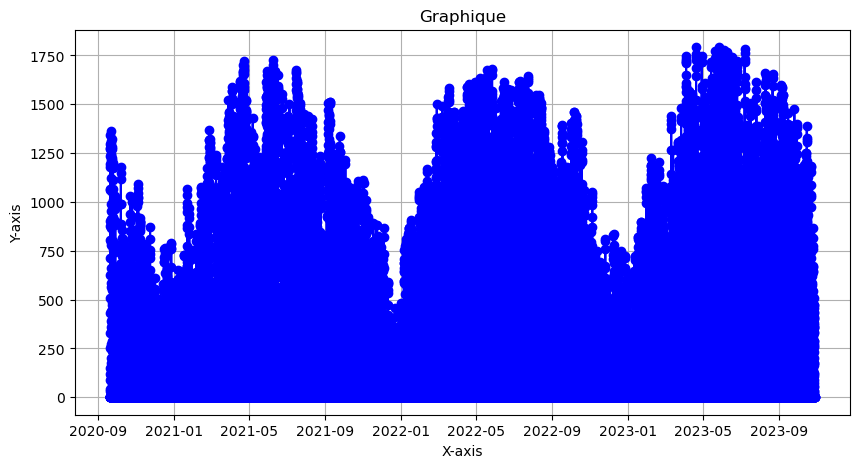

In [18]:
dataImputed = pd.concat([dataImputedNoDTM,dataRaw['dtm']],axis=1)
plot_data2D(dataImputed,'dtm','Solar_MW')


In [19]:
"""
Part : NC files
"""

'\nPart : NC files\n'

In [20]:
import netCDF4 as nc
import xarray as xr
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [90]:
dwd_solar = xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")

In [91]:
dwd_solar_features1 = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features2 = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_features3 = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()
dwd_solar_featuresInter = dwd_solar_features1.merge(dwd_solar_features2,how="outer",on=["ref_datetime","valid_datetime"])
dwd_solar_features = dwd_solar_featuresInter.merge(dwd_solar_features3,how="outer",on=["ref_datetime","valid_datetime"])

dwd_solar_features["ref_datetime"]=dwd_solar_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_features["valid_datetime"] = dwd_solar_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_features["valid_datetime"],unit="hours")




In [23]:
dwd_solar_features

,ref_datetime,valid_datetime,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.000000,0.450405,13.646173
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.000000,0.494018,13.670843
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.000000,0.546410,13.793360
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.000000,0.627071,13.907354
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.000000,0.681062,14.022113
...,...,...,...,...,...
415426,2023-10-27 00:00:00+00:00,2023-10-31 12:00:00+00:00,180.746119,0.810468,12.455963
415427,2023-10-27 00:00:00+00:00,2023-10-31 15:00:00+00:00,23.697193,0.459340,12.856787
415428,2023-10-27 00:00:00+00:00,2023-10-31 18:00:00+00:00,0.976647,0.069910,10.006506
415429,2023-10-27 00:00:00+00:00,2023-10-31 21:00:00+00:00,0.932845,0.652018,8.682965


In [24]:
'''dwd_Hornsea1 = xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
dwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")
dwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")'''
# Pas besoin de ce dataset la, on ne prédit plus la feature "Wind_MW"

'dwd_Hornsea1 = xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc")\ndwd_Hornsea1_features = dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()\ndwd_Hornsea1_features["ref_datetime"] = dwd_Hornsea1_features["ref_datetime"].dt.tz_localize("UTC")\ndwd_Hornsea1_features["valid_datetime"] = dwd_Hornsea1_features["ref_datetime"] + pd.TimedeltaIndex(dwd_Hornsea1_features["valid_datetime"],unit="hours")'

In [92]:
energy_df = dataImputed
energy_df['dtm'] = pd.to_datetime(energy_df['dtm'], utc=True)


modelling_table = dwd_solar_features
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").ffill()
modelling_table = modelling_table.drop(columns="ref_datetime",axis=1).reset_index()
modelling_table = dwd_solar_features.merge(energy_df,how="inner",left_on="valid_datetime",right_on="dtm")
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

Text(0, 0.5, 'Generation [MW]')

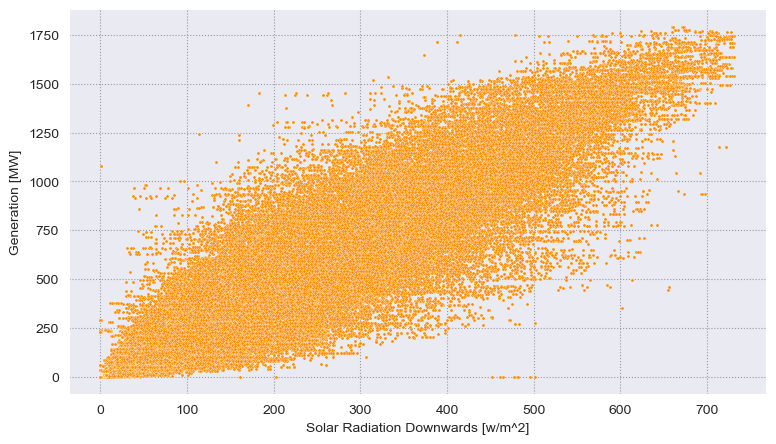

In [28]:
plt.figure(figsize=(9,5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=modelling_table, x="SolarDownwardRadiation", 
                y="Solar_MW", color='darkorange',s=5)
plt.xlabel('Solar Radiation Downwards [w/m^2]')
plt.ylabel('Generation [MW]')

In [299]:
modelling_table = dfPropre(dataRaw,dwd_solar)

In [90]:
"""
Part : Preprocessing 2 (Selection, creation of interesting features)
"""

'\nPart : Preprocessing 2 (Selection, creation of interesting features)\n'

In [53]:
modelling_table.isna().sum()
modelling_table.dtypes

SolarDownwardRadiation                     float64
CloudCover                                 float64
Temperature                                float64
MIP                                        float64
Solar_MW                                   float64
Solar_capacity_mwp                         float64
Solar_installedcapacity_mwp                float64
Wind_MW                                    float64
SS_Price                                   float64
boa_MWh                                    float64
DA_Price                                   float64
year                                       float64
month                                      float64
day                                        float64
hour                                       float64
minute                                     float64
second                                     float64
dtm                            datetime64[ns, UTC]
dtype: object

In [109]:
#a commenter plus tard quand la fonction fonctionnera
dfNoDTM  =modelling_table.drop(["dtm","ref_datetime","valid_datetime"],axis=1)
df = imputationKNN(dfNoDTM)

In [111]:
df

,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,-0.662734,-0.929595,0.441454,-1.138079,0.0,-0.863144,-1.013742,0.996641,-0.997707,0.074429,-0.995845,2020.0,9.0,20.0,0.0,0.0,0.0
1,-0.662734,-0.779066,0.445483,-1.047681,0.0,-0.863144,-1.013742,0.869766,-0.643881,0.074429,-0.997535,2020.0,9.0,20.0,1.0,0.0,0.0
2,-0.662734,-0.598231,0.465491,-1.052820,0.0,-0.863144,-1.013742,0.817830,-0.791795,0.074429,-0.997634,2020.0,9.0,20.0,2.0,0.0,0.0
3,-0.662734,-0.319826,0.484107,-1.049569,0.0,-0.863144,-1.013742,0.956212,-0.776614,0.074429,-0.992166,2020.0,9.0,20.0,3.0,0.0,0.0
4,-0.662734,-0.133476,0.502848,-1.096760,0.0,-0.863144,-1.013742,1.011841,-0.791406,0.074429,-0.994751,2020.0,9.0,20.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223275,-0.662756,-0.464912,-0.427519,-0.437758,0.0,1.818109,1.838887,-1.225791,0.018227,0.074429,-0.732300,2023.0,10.0,27.0,23.0,0.0,0.0
223276,-0.662659,-0.058706,-0.399942,-0.437758,0.0,1.818109,1.838887,-1.225791,0.018227,0.074429,-0.732300,2023.0,10.0,27.0,23.0,0.0,0.0
223277,-0.662651,0.177785,-0.431623,-0.437758,0.0,1.818109,1.838887,-1.225791,0.018227,0.074429,-0.732300,2023.0,10.0,27.0,23.0,0.0,0.0
223278,-0.662737,-0.792383,-0.430058,-0.437758,0.0,1.818109,1.838887,-1.225791,0.018227,0.074429,-0.732300,2023.0,10.0,27.0,23.0,0.0,0.0


In [113]:
df.columns

Index(['SolarDownwardRadiation', 'CloudCover', 'Temperature', 'MIP',
       'Solar_MW', 'Solar_capacity_mwp', 'Solar_installedcapacity_mwp',
       'Wind_MW', 'SS_Price', 'boa_MWh', 'DA_Price', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'Solar_MWh_credit'],
      dtype='object')

In [117]:
# Standarisation et Normalisation des features numériques

In [112]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scalerStand = StandardScaler()
scalerMin = MinMaxScaler()
numericalFeatures = ['Temperature', 'SolarDownwardRadiation', 'CloudCover', 'MIP', 'Wind_MW', 'SS_Price', 'boa_MWh', 'DA_Price','Solar_capacity_mwp', 'Solar_installedcapacity_mwp']
df[numericalFeatures] = scalerStand.fit_transform(df[numericalFeatures])
df[numericalFeatures] = scalerMin.fit_transform(df[numericalFeatures])
df


,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second
0,0.000165,0.450405,0.444993,0.050831,0.0,0.000253,0.0,0.835371,0.044476,1.0,0.037233,2020.0,9.0,20.0,0.0,0.0,0.0
1,0.000165,0.494018,0.445571,0.055332,0.0,0.000253,0.0,0.789053,0.055239,1.0,0.037157,2020.0,9.0,20.0,1.0,0.0,0.0
2,0.000165,0.546410,0.448438,0.055076,0.0,0.000253,0.0,0.770094,0.050740,1.0,0.037153,2020.0,9.0,20.0,2.0,0.0,0.0
3,0.000165,0.627071,0.451107,0.055238,0.0,0.000253,0.0,0.820612,0.051201,1.0,0.037398,2020.0,9.0,20.0,3.0,0.0,0.0
4,0.000165,0.681062,0.453793,0.052888,0.0,0.000253,0.0,0.840921,0.050751,1.0,0.037282,2020.0,9.0,20.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223275,0.000160,0.585036,0.320445,0.085700,0.0,0.972845,1.0,0.024033,0.075378,1.0,0.049027,2023.0,10.0,27.0,23.0,0.0,0.0
223276,0.000181,0.702725,0.324398,0.085700,0.0,0.972845,1.0,0.024033,0.075378,1.0,0.049027,2023.0,10.0,27.0,23.0,0.0,0.0
223277,0.000183,0.771242,0.319857,0.085700,0.0,0.972845,1.0,0.024033,0.075378,1.0,0.049027,2023.0,10.0,27.0,23.0,0.0,0.0
223278,0.000164,0.490159,0.320081,0.085700,0.0,0.972845,1.0,0.024033,0.075378,1.0,0.049027,2023.0,10.0,27.0,23.0,0.0,0.0


In [97]:
df['Solar_capacity_x_month'] = df['Solar_capacity_mwp'] * df['month']
df['Solar_capacity_x_hour'] = df['Solar_capacity_mwp'] * df['hour']

In [98]:
df['Solar_to_Wind_Ratio'] = df['Solar_MW'] / df['Wind_MW']
df['Solar_to_BoA_Ratio'] = df['Solar_MW'] / df['boa_MWh']

In [99]:
df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)
df['is_spring'] = df['month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)
df['is_autumn'] = df['month'].apply(lambda x: 1 if x in [9, 10, 11] else 0)
df


,ref_datetime,valid_datetime,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,...,second,dtm,Solar_capacity_x_month,Solar_capacity_x_hour,Solar_to_Wind_Ratio,Solar_to_BoA_Ratio,is_summer,is_winter,is_spring,is_autumn
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.000165,0.450405,0.444993,0.050831,0.0,0.000253,0.0,0.835371,...,0.0,2020-09-20 00:00:00+00:00,0.002279,0.000000,0.0,0.0,0,0,0,1
1,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.000165,0.494018,0.445571,0.055332,0.0,0.000253,0.0,0.789053,...,0.0,2020-09-20 01:00:00+00:00,0.002279,0.000253,0.0,0.0,0,0,0,1
2,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.000165,0.546410,0.448438,0.055076,0.0,0.000253,0.0,0.770094,...,0.0,2020-09-20 02:00:00+00:00,0.002279,0.000507,0.0,0.0,0,0,0,1
3,2020-09-20 00:00:00+00:00,2020-09-20 03:00:00+00:00,0.000165,0.627071,0.451107,0.055238,0.0,0.000253,0.0,0.820612,...,0.0,2020-09-20 03:00:00+00:00,0.002279,0.000760,0.0,0.0,0,0,0,1
4,2020-09-20 00:00:00+00:00,2020-09-20 04:00:00+00:00,0.000165,0.681062,0.453793,0.052888,0.0,0.000253,0.0,0.840921,...,0.0,2020-09-20 04:00:00+00:00,0.002279,0.001013,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414957,2023-10-26 00:00:00+00:00,2023-10-27 23:00:00+00:00,0.000160,0.585036,0.320445,0.085700,0.0,0.972845,1.0,0.024033,...,0.0,2023-10-27 23:00:00+00:00,9.728451,22.375436,0.0,0.0,0,0,0,1
414958,2023-10-26 06:00:00+00:00,2023-10-27 23:00:00+00:00,0.000181,0.702725,0.324398,0.085700,0.0,0.972845,1.0,0.024033,...,0.0,2023-10-27 23:00:00+00:00,9.728451,22.375436,0.0,0.0,0,0,0,1
414959,2023-10-26 12:00:00+00:00,2023-10-27 23:00:00+00:00,0.000183,0.771242,0.319857,0.085700,0.0,0.972845,1.0,0.024033,...,0.0,2023-10-27 23:00:00+00:00,9.728451,22.375436,0.0,0.0,0,0,0,1
414960,2023-10-26 18:00:00+00:00,2023-10-27 23:00:00+00:00,0.000164,0.490159,0.320081,0.085700,0.0,0.972845,1.0,0.024033,...,0.0,2023-10-27 23:00:00+00:00,9.728451,22.375436,0.0,0.0,0,0,0,1


In [100]:
df['Log_Solar_MW'] = np.log1p(df['Solar_MW'])


In [101]:
df['temp_squared'] = df['Temperature'] ** 2
df['radiation_x_cloudcover'] = df['SolarDownwardRadiation'] * df['CloudCover']


In [102]:
correlationMatrix = df.corr()
correlationMatrix

,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,...,Solar_capacity_x_hour,Solar_to_Wind_Ratio,Solar_to_BoA_Ratio,is_summer,is_winter,is_spring,is_autumn,Log_Solar_MW,temp_squared,radiation_x_cloudcover
SolarDownwardRadiation,1.000000,-0.091819,0.459128,-0.012821,0.946895,0.087988,0.091773,-0.174310,-0.022331,0.023033,...,0.068170,0.074176,0.927501,0.252844,-0.246846,0.120261,-0.127006,0.827217,0.489188,0.878370
CloudCover,-0.091819,1.000000,0.108329,-0.081089,-0.079818,-0.005260,-0.009926,0.128729,-0.063560,0.017351,...,-0.016044,-0.012169,-0.081940,-0.045947,0.011258,-0.042897,0.075534,0.026540,0.062734,0.161620
Temperature,0.459128,0.108329,1.000000,0.060395,0.425117,0.187560,0.202062,-0.146805,0.026385,0.025149,...,0.215053,0.039329,0.414175,0.588774,-0.546697,-0.198449,0.142540,0.413447,0.972590,0.440212
MIP,-0.012821,-0.081089,0.060395,1.000000,-0.024736,-0.120909,-0.077705,-0.156000,0.783361,0.034168,...,-0.048718,-0.005320,-0.028083,0.068556,0.047208,-0.090674,-0.023597,0.026506,0.111120,-0.017639
Solar_MW,0.946895,-0.079818,0.425117,-0.024736,1.000000,0.091709,0.095540,-0.136504,-0.041658,0.012449,...,0.082623,0.078147,0.982653,0.191836,-0.202661,0.107778,-0.097470,0.811338,0.454339,0.830264
Solar_capacity_mwp,0.087988,-0.005260,0.187560,-0.120909,0.091709,1.000000,0.997305,-0.057874,-0.089938,0.012815,...,0.780263,0.018109,0.089242,0.141264,-0.125540,0.044063,-0.060122,0.070787,0.182707,0.086685
Solar_installedcapacity_mwp,0.091773,-0.009926,0.202062,-0.077705,0.095540,0.997305,1.000000,-0.058113,-0.057743,0.009932,...,0.778170,0.017834,0.093148,0.148900,-0.132136,0.039805,-0.057110,0.073345,0.197578,0.090038
Wind_MW,-0.174310,0.128729,-0.146805,-0.156000,-0.136504,-0.057874,-0.058113,1.000000,-0.110386,0.023698,...,-0.041894,-0.060001,-0.135230,-0.234364,0.205235,-0.074239,0.103752,-0.116186,-0.177157,-0.147199
SS_Price,-0.022331,-0.063560,0.026385,0.783361,-0.041658,-0.089938,-0.057743,-0.110386,1.000000,0.040631,...,-0.031553,-0.006616,-0.045774,0.046125,0.052222,-0.064331,-0.032170,0.007595,0.072121,-0.023662
boa_MWh,0.023033,0.017351,0.025149,0.034168,0.012449,0.012815,0.009932,0.023698,0.040631,1.000000,...,0.021123,0.003010,-0.052786,0.039745,-0.015721,-0.000765,-0.022843,0.036582,0.030999,0.032285


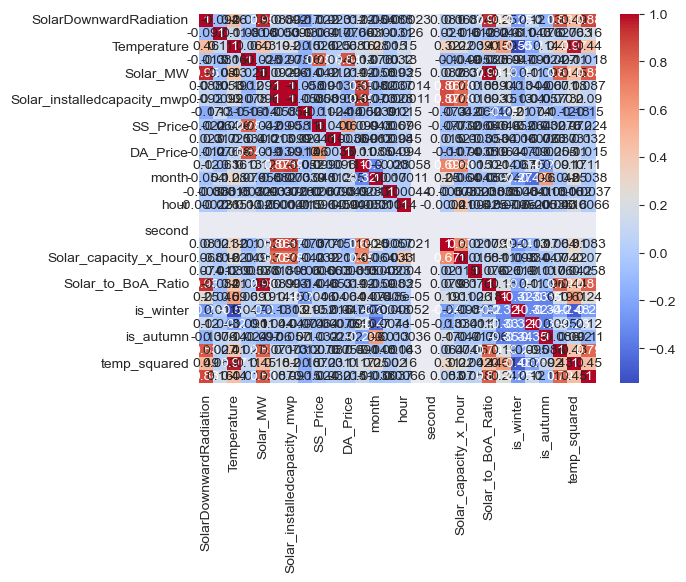

In [119]:
import seaborn as sns

sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm')
plt.show()

In [103]:
featureSolar = correlationMatrix['Solar_MW']
threshold = 0.7
high_correlation_features = featureSolar[abs(featureSolar) >= threshold]
high_correlation_features



SolarDownwardRadiation    0.946895
Solar_MW                  1.000000
Solar_to_BoA_Ratio        0.982653
Log_Solar_MW              0.811338
radiation_x_cloudcover    0.830264
Name: Solar_MW, dtype: float64

In [104]:
filtered_df = df[high_correlation_features.index.tolist()]


In [105]:
filtered_df2 = imputationKNN(filtered_df)

,SolarDownwardRadiation,Solar_MW,Solar_to_BoA_Ratio,Log_Solar_MW,radiation_x_cloudcover
0,0.000165,0.0,0.0,0.0,0.000074
1,0.000165,0.0,0.0,0.0,0.000082
2,0.000165,0.0,0.0,0.0,0.000090
3,0.000165,0.0,0.0,0.0,0.000103
4,0.000165,0.0,0.0,0.0,0.000112
...,...,...,...,...,...
223275,0.000160,0.0,0.0,0.0,0.000094
223276,0.000181,0.0,0.0,0.0,0.000127
223277,0.000183,0.0,0.0,0.0,0.000141
223278,0.000164,0.0,0.0,0.0,0.000081


In [288]:
dataPD2024 = pd.read_csv("Energy_Data_20200920_20240118.csv")
dataNC2024_1 = xr.open_dataset("dwd_icon_eu_pes10_20240108_20240129.nc")
dataNC2024_2 = xr.open_dataset("dwd_icon_eu_pes10_20231027_20240108.nc")

In [289]:
dataPD2024
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'], utc=True)


In [290]:
dataNC2024_1

<xarray.Dataset>
Dimensions:                 (reference_time: 85, valid_time: 93, point: 20)
Coordinates:
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * reference_time          (reference_time) datetime64[ns] 2024-01-08 ... 20...
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 ...
    Temperature             (reference_time, valid_time, point) float32 ...

In [291]:
dataNC2024_2

<xarray.Dataset>
Dimensions:                 (valid_time: 93, reference_time: 293, point: 20)
Coordinates:
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
    latitude                (point) float64 ...
    longitude               (point) float64 ...
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * reference_time          (reference_time) datetime64[ns] 2023-10-27 ... 20...
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 ...
    Temperature             (reference_time, valid_time, point) float32 ...

In [292]:
dataNC2024 = xr.merge([dataNC2024_1, dataNC2024_2], join='outer')
dataNC2024

<xarray.Dataset>
Dimensions:                 (reference_time: 377, valid_time: 93, point: 20)
Coordinates:
  * reference_time          (reference_time) datetime64[ns] 2023-10-27 ... 20...
    latitude                (point) float64 52.49 52.88 52.14 ... 52.88 52.08
    longitude               (point) float64 0.4012 0.7907 ... 1.192 -0.01135
  * point                   (point) int64 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
  * valid_time              (valid_time) int64 0 1 2 3 4 ... 108 111 114 117 120
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 0.659...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 0.0 ....
    Temperature             (reference_time, valid_time, point) float32 8.36 ...

In [293]:
dataNC2024 = dataNC2024.rename({'reference_time': 'ref_datetime'})
dataNC2024 = dataNC2024.rename({'valid_time': 'valid_datetime'})



In [294]:
ds_sorted = dataNC2024.sortby('ref_datetime')
# Convertir le timestamp en numpy.datetime64

date_limite = np.datetime64('2024-01-18')
date_début = np.datetime64('2023-10-28')

# Sélectionnez les données jusqu'à la date limite inclusive
dataNC2024 = ds_sorted.sel(ref_datetime=slice(date_début, date_limite )) 

In [295]:
dataPD2024['dtm'] = pd.to_datetime(dataPD2024['dtm'])

# Définir les dates de début et de fin
date_début = pd.Timestamp('2023-10-28', tz='UTC')
date_limite = pd.Timestamp('2024-01-18', tz='UTC')

# Filtrer les données pour inclure uniquement les dates entre date_debut et date_fin
dataPD2024 = dataPD2024[(dataPD2024['dtm'] >= date_début) & (dataPD2024['dtm'] <= date_limite)]

dataPD2024



,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
54384,2023-10-28 00:00:00+00:00,102.70,0.0,2453.093454,2609.200511,39.364,133.00,0.0,58.27
54385,2023-10-28 00:30:00+00:00,98.19,0.0,2453.093454,2609.200511,57.204,12.00,0.0,58.27
54386,2023-10-28 01:00:00+00:00,71.73,0.0,2453.093454,2609.200511,72.764,0.00,0.0,51.71
54387,2023-10-28 01:30:00+00:00,68.20,0.0,2453.093454,2609.200511,86.964,0.00,0.0,51.71
54388,2023-10-28 02:00:00+00:00,71.15,0.0,2453.093454,2609.200511,82.282,-5.00,0.0,48.30
...,...,...,...,...,...,...,...,...,...
58316,2024-01-17 22:00:00+00:00,76.48,0.0,2448.464405,2609.200511,318.200,98.90,0.0,65.77
58317,2024-01-17 22:30:00+00:00,71.34,0.0,2448.464405,2609.200511,428.040,98.90,0.0,65.77
58318,2024-01-17 23:00:00+00:00,67.92,0.0,2448.464405,2609.200511,417.340,57.31,0.0,66.93
58319,2024-01-17 23:30:00+00:00,72.48,0.0,2448.407255,2609.200511,408.820,58.00,0.0,66.93


In [296]:
derniereDateNC = dataNC2024['ref_datetime'].max().values
derniereDateNC

numpy.datetime64('2024-01-18T00:00:00.000000000')

In [281]:

derniereDatePD = dataPD2024["dtm"].max()
derniereDatePD

Timestamp('2024-01-18 00:00:00+0000', tz='UTC')

In [282]:
premiereeDateNC = dataNC2024['ref_datetime'].min().values
premiereeDateNC

numpy.datetime64('2023-10-28T00:00:00.000000000')

In [283]:
premiereeDatePD = dataPD2024["dtm"].min()
premiereeDatePD

Timestamp('2023-10-28 00:00:00+0000', tz='UTC')

In [301]:
trainingSet = dfPropre2(dataPD2024,dataNC2024)

In [302]:
trainingSet

,SolarDownwardRadiation,CloudCover,Temperature,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price,year,month,day,hour,minute,second


In [106]:
"""
Part : Prediction with Linear Regression
"""

'\nPart : Prediction with Linear Regression\n'

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
Accuracies = []
model = LinearRegression()
X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred=np.round(y_pred)
accuracy = (y_test==y_pred).mean()
Accuracies.append(accuracy)
pd.Series(Accuracies).describe()

count    1.000000
mean     0.008241
std           NaN
min      0.008241
25%      0.008241
50%      0.008241
75%      0.008241
max      0.008241
dtype: float64

In [85]:
"""
Part : Prediction with Random Forest
"""

'\nPart : Prediction with Random Forest\n'

In [108]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
Accuracies = []
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
y_pred = np.round(model.predict(X_test))
accuracy = (y_test==y_pred).mean()
Accuracies.append(accuracy)
pd.Series(Accuracies).describe()

count    1.000000
mean     0.658142
std           NaN
min      0.658142
25%      0.658142
50%      0.658142
75%      0.658142
max      0.658142
dtype: float64

In [ ]:
"""
Part : Prediction with Neural Networks
"""

In [89]:
#Prend beaucoup de temps

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10,5), random_state=0)
Accuracies = []
X,y = filtered_df2.drop('Solar_MW',axis=1),round(filtered_df2['Solar_MW'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train,y_train)
y_pred = np.round(model.predict(X_test))
accuracy = (y_test==y_pred).mean()
Accuracies.append(accuracy)
pd.Series(Accuracies).describe()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning:

Training interrupted by user.



count    1.000000
mean     0.565546
std           NaN
min      0.565546
25%      0.565546
50%      0.565546
75%      0.565546
max      0.565546
dtype: float64

In [ ]:
"""
Part : Prediction with ...
"""

In [ ]:
"""
Part : Best Model 
"""

In [41]:
"""
Part : DashBoard
"""

'\nPart : DashBoard\n'

In [88]:
from dash import Dash, html, dcc, Input, Output, callback
import pandas as pd
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# Initialisation de l'application Dash
app = Dash(__name__)

# Layout de l'application
app.layout = html.Div([
    html.Div(children='Régression Linéaire avec Dash'),
    html.Button('Lancer la prédiction', id='predict-button'),
    dcc.Graph(id='prediction-graph'),
])

# Assumons que data_final et data_final2 sont vos DataFrames prédéfinis

dataImputed2 = pd.DataFrame({
    'dtm': pd.date_range(start='2021-05-01', periods=50, freq='D'),
    'Solar_MW': np.random.rand(50) * 100
})

# Callback pour mettre à jour le graphique avec les prédictions
@app.callback(
    Output('prediction-graph', 'figure'),
    Input('predict-button', 'n_clicks')
)
def update_graph(n_clicks):
    if n_clicks is None:
        # Ne rien afficher avant que le bouton soit cliqué
        return go.Figure()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Création du graphique de prédiction
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataImputed2['dtm'], y=y_pred, mode='markers', name='Données réelles'))
    fig.add_trace(go.Scatter(x=dataImputed2['dtm'], y=y_test, mode='markers', name='Données réelles'))
    fig.update_layout(title='Comparaison des Prédictions et des Données Réelles', xaxis_title='Date', yaxis_title='Solar MW')

    return fig

# Exécuter l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)  # Utilisez un numéro de port différent si nécessaire


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

